# Анализ поведения пользователей в мобильном приложении

Задача продуктовых менеджеров мобильного приложения «Ненужные вещи» — изучить поведение пользователей, чтобы определить наиболее частые модели поведения, которые приводят к целевому действию – просмотру контактов автора объявления.

Это необходимо для управления вовлечённостью клиентов и адаптации приложения к потребностям целевой и смежной аудитории на основе данных о поведении пользователей.

Основные вопросы исследования:
- Как взаимосвязаны целевое событие и другие действия пользователей?
- Какие сценарии и модели поведения наиболее часто приводят к просмотру контактов?
- Как выглядят воронки для основных сценариев у пользователей, просматривающих контакты?

Также планируется оценить, как часто пользователи, которые просматривают контакты, совершают различные действия, и сравнить это с теми, кто этого не делает.

Анализ поведения пользователей поможет проверить гипотезы, которые влияют на просмотр контактов.

<a id='table_of_contents'></a>
**План работы:**
- Получить данные из файлов и предварительно изучить их
- Подготовить данные для анализа
- Провести исследовательский анализ данных
    - Общий анализ
    - Анализ группы пользователей, которые хотя бы раз совершили целевое действие
- Проверить гипотезы
- Сформулировать общие выводы и рекомендации

**Описание данных:**

Столбцы в `/datasets/mobile_sources.csv`:
- userId — идентификатор пользователя,
- source — источник, с которого пользователь установил приложение.

Столбцы в `/datasets/mobile_dataset.csv`:
- event.time — время совершения,
- user.id — идентификатор пользователя,
- event.name — действие пользователя. Виды действий:
    - advert_open — открыл карточки объявления,
    - photos_show — просмотрел фотографий в объявлении,
    - tips_show — увидел рекомендованные объявления,
    - tips_click — кликнул по рекомендованному объявлению,
    - contacts_show и show_contacts — посмотрел номер телефона,
    - contacts_call — позвонил по номеру из объявления,
    - map — открыл карту объявлений,
    - search_1 — search_7 — разные действия, связанные с поиском по сайту,
    - favorites_add — добавил объявление в избранное.

##  Чтение данных


In [1]:
#импортируем библиотеки для работы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
!pip install kaleido
import requests
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy import stats as st
import warnings
#устанавливаем единый стиль для графиков
sns.set_palette(sns.color_palette('flare'))
palette = sns.color_palette('flare')
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

#выводим все стоблцы в таблицах
pd.set_option('display.max_columns', None)

In [2]:
#функция для первичного изучения датасета
def show_info(df, whole=True):
    if whole:
        display(df.info())
        print('-' * 25)
        print('Проверка на дубликаты:', df.duplicated().sum())
        print('-' * 25)
        print('Проверка на пропуски')
        display(df.isnull().sum())
        print('-' * 25)
        print('Статистика')
        display(df.describe(include=['object']).T)
        if not df.select_dtypes(include=['int64', 'float64']).empty:
            display(df.select_dtypes(include=['int64', 'float64']).describe().T)
        display(df.head())
    else:
        display(df.info())
        display(df.describe(include=['object']).T)
        if not df.select_dtypes(include=['int64', 'float64']).empty:
            display(df.select_dtypes(include=['int64', 'float64']).describe().T)
        display(df.head())

In [3]:
#считываем данные
sources, logs = (pd.read_csv('/datasets/mobile_sources.csv'),
                 pd.read_csv('/datasets/mobile_dataset.csv'))
#применяем функцию к источникам
show_info(sources)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

-------------------------
Проверка на дубликаты: 0
-------------------------
Проверка на пропуски


userId    0
source    0
dtype: int64

-------------------------
Статистика


,count,unique,top,freq
userId,4293,4293,a8e60154-cf38-47ed-bd78-eb4d44cb78c0,1
source,4293,3,yandex,1934


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


- Столбец `userId` нужно привести к нижнему регистру и разделить слова в наименовании.
- В датасете с источниками 4293 уникальных пользователя.
- Пользователи приходят из трёх источников, самый популярный — yandex. Также есть варианты: google и other.
- Пропусков и дубликатов в столбцах нет.

In [4]:
#применяем функцию к логам
show_info(logs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

-------------------------
Проверка на дубликаты: 0
-------------------------
Проверка на пропуски


event.time    0
event.name    0
user.id       0
dtype: int64

-------------------------
Статистика


,count,unique,top,freq
event.time,74197,74197,2019-10-29 10:53:00.160015,1
event.name,74197,16,tips_show,40055
user.id,74197,4293,cb36854f-570a-41f4-baa8-36680b396370,478


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


- Все наименования столбцов необходимо привести к единому виду, заменив точку нижним подчёркиванием.
- Столбец со временем нужно привести к временному типу.
- В логах хранится 74197 действий в приложении.
- Пропусков и точных дубликатов в датасете нет, но это может измениться после перевода даты — нужно будет дополнительно проверить дубликаты, так как логи хранят информацию до милисекунд.
- Самое распространённое действие: tips_show — факт показа рекомендованных объявлений занимает большую часть датасета.
- Количество уникальных юзеров совпадает с датасетом об источниках — можно объединить датасеты для сохранения этой информации в конечном наборе данных.
- Наибольшее количество действий, зафиксированное за пользователем — 478 записей.
- В предварительном описании данных есть действия-неявные дубликаты, нужно будет их также проверить и привести к единому виду.

## Предобработка данных

Большую часть преобразований, которые мы наметили при изучении первоначальных датасетов, можно совершить в одной ячейке. Но прежде чем устранять дубликаты в действиях, выведем уникальные значения из столбца `event.name`.

In [5]:
list(logs['event.name'].unique())

['advert_open',
 'tips_show',
 'map',
 'contacts_show',
 'search_4',
 'search_5',
 'tips_click',
 'photos_show',
 'search_1',
 'search_2',
 'search_3',
 'favorites_add',
 'contacts_call',
 'search_6',
 'search_7',
 'show_contacts']

<a id='section_id'></a>
Да, есть два действия: `contacts_show` и `show_contacts`, которые отвечают одно и то же — просмотр контактов в объявлении. Это может быть связано с изменением логики сбора информации или размещением данных о разных группах пользователей на разных серверах, где названия целевых действий различаются.

Для нашей работы не требуется выяснять точную причину появления этого неявного дубликата. Поэтому мы просто заменим одно из названий. Кроме того мы можем привести различные действия в поиске к единому значению, так как углубляться в тонкости поисковых запросов в рамках анализа нам не нужно.

In [6]:
#приводим столбцы к единому виду
sources.columns = sources.columns.str.replace('userId', 'user_id')
logs.columns = logs.columns.str.replace('.', '_')
#удалим неявные дубликаты в логах действий
logs['event_name'] = (logs['event_name']
                      .str.replace('show_contacts','contacts_show')
                      .str.replace('^search_\d+','search', regex=True))
#преобразовываем время
logs['event_time'] = pd.to_datetime(logs['event_time'])
#добавляем столбец с округлением до секунд
logs['event_s'] = logs['event_time'].dt.floor('S')
#объединяем логи и источники
df = logs.merge(sources, on=['user_id'], how='left')
#проверяем результат
show_info(df, whole=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   event_s     74197 non-null  datetime64[ns]
 4   source      74197 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 3.4+ MB


None

,count,unique,top,freq
event_name,74197,9,tips_show,40055
user_id,74197,4293,cb36854f-570a-41f4-baa8-36680b396370,478
source,74197,3,yandex,34286


,event_time,event_name,user_id,event_s,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:01,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:07,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:56,yandex


- Замена наименований столбцов и объединение данных прошло успешно: все строки сохранены, количество уникальных пользователей неизменно.
- В отдельном столбце теперь хранится информация о времени лога с округлением до секунд. Это позволит нам найти дубликаты действий для каждого пользователя и сохранить точное время каждого уникального действия.

### Удаление дубликатов

In [7]:
#считаем дубликаты действий до секунд
df[['user_id','event_name','event_s']].duplicated().sum()

1224

Если сравнивать по каждому пользователю одинаковые действия в рамках одной секунды, то обнаруживаются 1224 дубликата. Выведем часть строк таких дублей.

In [8]:
df[df[['user_id','event_name','event_s']].duplicated(keep=False)]

,event_time,event_name,user_id,event_s,source
395,2019-10-07 11:00:20.067755,tips_show,fb667205-a708-4693-832d-363a30022cfc,2019-10-07 11:00:20,yandex
396,2019-10-07 11:00:20.161836,tips_show,fb667205-a708-4693-832d-363a30022cfc,2019-10-07 11:00:20,yandex
421,2019-10-07 11:10:39.701908,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:39,yandex
422,2019-10-07 11:10:39.913731,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:39,yandex
423,2019-10-07 11:10:40.185470,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:40,yandex
...,...,...,...,...,...
73760,2019-11-03 21:27:06.601535,photos_show,da4b7af3-c603-457a-8506-71d90077417b,2019-11-03 21:27:06,google
73793,2019-11-03 21:36:08.014431,search,78756227-406d-4cd5-8778-966d50b4f46d,2019-11-03 21:36:08,yandex
73794,2019-11-03 21:36:08.929838,search,78756227-406d-4cd5-8778-966d50b4f46d,2019-11-03 21:36:08,yandex
73838,2019-11-03 21:45:22.239469,photos_show,1af9ffcd-2c77-4de0-9d35-3ff30604c9bd,2019-11-03 21:45:22,google


Есть совпадения по различным действиям, не только по просмотрам. Более того, количество выведенных строк увеличилось менее чем в два раза по сравнению с количеством дублей. Это означает, что некоторые действия повторялись в течение одной секунды более двух раз.

Также по выведенным строкам видно, что в некоторых случаях одно действие могло длиться больше секунды. Например, просмотр карт у пользователя с идентификатором `ed13f6f0-08f4-4561-852e-456580f7a40d`: первые дубликаты произошли в 11:10:39, но даже на 40-й секунде действие повторялось неоднократно, раз оно было выведено в списке дубликатов.

Запомним индекс 421 для последующей проверки этого участка. Чтобы удалить такие дубликаты, нам потребуется создать вспомогательные столбцы для проверки отсортированных по времени событий на наличие дубликатов в течение соседних секунд.

In [9]:
#сортируем данные по времени события
df = df.sort_values(by=['user_id', 'event_time', 'event_name'])
#создаём столбец со сдвигом во времени для сравнения с предыдущей строкой
df['prev_event_time'] = df.groupby(['user_id', 'event_name'])['event_time'].shift(1)
#сравниваем между текущим и предыдущим временем события в рамках одной секунды, маркируя дубликаты
df['is_duplicate'] = (df['event_time'] - df['prev_event_time']).dt.total_seconds() < 1
#проверяем результат на участке, который ранее уже видели
df.loc[421:431]

,event_time,event_name,user_id,event_s,source,prev_event_time,is_duplicate
421,2019-10-07 11:10:39.701908,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:39,yandex,NaT,False
422,2019-10-07 11:10:39.913731,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:39,yandex,2019-10-07 11:10:39.701908,True
423,2019-10-07 11:10:40.185470,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:40,yandex,2019-10-07 11:10:39.913731,True
424,2019-10-07 11:10:40.604284,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:40,yandex,2019-10-07 11:10:40.185470,True
425,2019-10-07 11:10:40.873885,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:10:40,yandex,2019-10-07 11:10:40.604284,True
429,2019-10-07 11:11:32.094258,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:11:32,yandex,2019-10-07 11:10:40.873885,False
430,2019-10-07 11:11:32.161722,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:11:32,yandex,2019-10-07 11:11:32.094258,True
431,2019-10-07 11:11:32.205308,map,ed13f6f0-08f4-4561-852e-456580f7a40d,2019-10-07 11:11:32,yandex,2019-10-07 11:11:32.161722,True


Пользователь активно изучает карту, однако некоторые его действия можно рассматривать как дубли, поскольку они повторяются с небольшим интервалом. Возможно, речь идёт о двойных кликах, которые не представляют интереса для нашего анализа.

Стоит отметить, что действия с индексами 421 и 429 отличаются друг от друга более чем на секунду — и не помечены как дубликаты.

In [10]:
#удаляем дубликаты
df = df[~df['is_duplicate']]
#удаляем вспомогательные столбцы
df = df.drop(columns=['prev_event_time','is_duplicate','event_s'])
#проверяем результат на рассматриваемом ранее участке
df.loc[421::]

,event_time,event_name,user_id,source
421,2019-10-07 11:10:39.701908,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
429,2019-10-07 11:11:32.094258,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
1541,2019-10-07 18:57:54.727097,tips_show,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
1554,2019-10-07 19:01:35.089161,tips_show,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
1561,2019-10-07 19:05:33.146777,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
...,...,...,...,...
72584,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
72589,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
72684,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
72688,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google


Дубликаты с картой у пользователя успешно удалены, а строки с индексами 421 и 429 сохранились. Очистка датасета прошла успешно. Проверим, как сильно уменьшился наш датасет.

In [11]:
#выводим информацию по датасету
show_info(df, whole=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72401 entries, 805 to 72689
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  72401 non-null  datetime64[ns]
 1   event_name  72401 non-null  object        
 2   user_id     72401 non-null  object        
 3   source      72401 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 4.8+ MB


None

,count,unique,top,freq
event_name,72401,9,tips_show,39758
user_id,72401,4293,cb36854f-570a-41f4-baa8-36680b396370,467
source,72401,3,yandex,33579


,event_time,event_name,user_id,source
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other


Мы удалили 1796, или 2,4%, дубликатов в данных, очистив не только одинаковые действия, которые происходили в течение одной секунды, но и повторяющиеся действия, которые происходили в соседних секундах. Количество уникальных пользователей сохранено.

### Добавление новых столбцов

<a id='section_id1'></a>
Чтобы провести анализ, нам нужно рассмотреть каждую группу пользователей отдельно: тех, кто хотя бы раз просматривал контакты, и тех, кто не делал этого за исследуемый период.

Для выделения этих групп мы отберём пользователей, у которых хотя бы однажды было действие `contacts_show`, а затем сравним их идентификаторы с основным датасетом и проставим флаги в новый столбец.

In [12]:
#отбираем пользователей, совершивших целевое действие
target_users = df.query('event_name == "contacts_show"')['user_id'].unique()
#добавляем новый столбец
df['key_action'] = df['user_id'].isin(target_users).astype(int)
#проверяем результат
df.head()

,event_time,event_name,user_id,source,key_action
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0


<a id='section_id2'></a>
Добавлен новый столбец для разделения пользователей на группы в зависимости от совершения целевого действия. 

Для удобства работы с датой, выделим её в отдельный столбец.

In [13]:
#преобразовываем время в новой колонке
df['day'] = pd.to_datetime(df['event_time']).dt.normalize()
#проверяем результат
df.head()

,event_time,event_name,user_id,source,key_action,day
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07


<a id='section_id3'></a>
Мы успешно создали столбец с днями, когда пользователи совершали действия в приложении. 

Теперь нам нужно для каждого пользователя определить отдельные сеансы использования приложения. Но сначала нужно решить, какой промежуток времени бездействия считать таймаутом.

В индустрии стандартом является таймаут в 30 минут. Это значение учитывает короткие периоды бездействия, но при этом достаточно велико, чтобы объединить действия, выполненные в течение одного сеанса использования приложения или веб-страницы. Однако период бездействия, после которого считается, что сессия завершена, можно настроить вручную. 

Чтобы определить время бездействия, применим методы кластеризации, группируя временные интервалы между действиями пользователей. Это позволит определить естественные кластеры, которые могут подсказать оптимальное время таймаута. Чтобы сэкономить время, не будем строить дендрограмму, а проверим несколько вариантов кластеров для сравнения.

In [14]:
#сортируем датасет по user_id и event_time
df = df.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)
#вычисляем разницу во времени между событиями для каждого пользователя
df['time_diff'] = df.groupby('user_id')['event_time'].diff()
#подготавливаем данные для кластеризации
time_diff = df['time_diff'].dt.total_seconds().dropna().values.reshape(-1, 1)
#разбиваем логи на 2 кластера
km2 = KMeans(n_clusters=2, random_state=0)
km2.fit(time_diff)
#определяем средние значения временных интервалов в минутах
np.round(km2.cluster_centers_ / 60, 2) 

array([[  100.11],
       [12528.66]])

Минимальный средний промежуток составляет 1 час 40 минут. Однако, учитывая, что во второй группе пользователи активны менее чем раз в неделю, по ним нельзя судить о таймауте.

In [15]:
#разбиваем логи на 3 кластера
km3 = KMeans(n_clusters=3, random_state=0)
km3.fit(time_diff)
#определяем средние значения временных интервалов в минутах
np.round(km3.cluster_centers_ / 60, 2) 

array([[   60.54],
       [20209.45],
       [ 7005.35]])

Если разделить данные на три кластера, то минимальный средний промежуток времени между логами будет около часа. Остальные временные интервалы превышают сутки, что не подходит для определения сессий в нашем случае.

In [16]:
#разбиваем логи на 4 кластера
km4 = KMeans(n_clusters=4, random_state=0)
km4.fit(time_diff)
#определяем средние значения временных интервалов в минутах
np.round(km4.cluster_centers_ / 60, 2)

array([[   39.02],
       [10960.77],
       [22968.14],
       [ 4189.56]])

Если разделить логи на четыре кластера, то минимальное среднее время между действиями пользователей в приложении составит 39 минут.

In [17]:
#разбиваем логи на 5 кластеров
km5 = KMeans(n_clusters=5, random_state=0)
km5.fit(time_diff)
#определяем средние значения временных интервалов в минутах
np.round(km5.cluster_centers_ / 60, 2)

array([[   36.97],
       [16295.  ],
       [ 3742.01],
       [27794.73],
       [ 9072.8 ]])

Среди пяти кластеров минимальный средний промежуток времени между действиями пользователей составляет около 37 минут. Разница между группами с минимальным таймаутом, полученными при разделении логов на четыре и пять групп, не является значительной, поэтому дальше нет смысла увеличивать количество кластеров.

Во всех вариантах наблюдаются кластеры с промежутками более суток, что указывает на редкую активность пользователей в некоторых группах. Для определения таймаута выберем 60 минут, так как это значение находится между минимальными временными интервалами и подходит для большинства пользователей, обеспечивая баланс между точностью и практичностью.

In [18]:
#устанавливаем таймаут для начала новой сессии
timeout = pd.Timedelta(minutes=60)
#создаём идентификатор сессии, который увеличивается при превышении таймаута
df['session_group'] = (df['time_diff'] > timeout).cumsum()
#создаём уникальный идентификатор сессии для всего датафрейма
df['session_id'] = df.groupby(['user_id', 'session_group'], sort=False).ngroup() + 1
#удаляем вспомогательные столбцы
df = df.drop(columns=['time_diff', 'session_group'])
#проверяем результат на рандомном участке
df.loc[186:190]

,event_time,event_name,user_id,source,key_action,day,session_id
186,2019-10-13 10:29:45.770690,photos_show,006f6ced-225b-4f9c-9f17-23404bc6835f,yandex,0,2019-10-13,26
187,2019-10-13 10:30:57.151587,photos_show,006f6ced-225b-4f9c-9f17-23404bc6835f,yandex,0,2019-10-13,26
188,2019-10-20 14:57:06.080501,contacts_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,2019-10-20,27
189,2019-10-22 19:59:00.140978,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,2019-10-22,28
190,2019-10-22 20:20:58.919595,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,2019-10-22,28


<a id='section_id4'></a>
Для каждой сессии мы создали уникальный идентификатор. Благодаря этому мы можем высчитать, сколько времени пользователь провёл в приложении при каждом своём подключении.

In [19]:
#создаём сводную таблицу по сессиям
session_times = df.groupby('session_id')['event_time'].agg(['min', 'max'])
#высчитываем длительность каждой сессии
session_times['session_time'] = (session_times['max'] - session_times['min']).dt.total_seconds().astype(int)
#добавляем новый столбец
df = df.merge(session_times['session_time'], on='session_id', how='left')
#проверяем результат на рандомном участке
df.loc[186:190]

,event_time,event_name,user_id,source,key_action,day,session_id,session_time
186,2019-10-13 10:29:45.770690,photos_show,006f6ced-225b-4f9c-9f17-23404bc6835f,yandex,0,2019-10-13,26,544
187,2019-10-13 10:30:57.151587,photos_show,006f6ced-225b-4f9c-9f17-23404bc6835f,yandex,0,2019-10-13,26,544
188,2019-10-20 14:57:06.080501,contacts_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,2019-10-20,27,0
189,2019-10-22 19:59:00.140978,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,2019-10-22,28,3043
190,2019-10-22 20:20:58.919595,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,1,2019-10-22,28,3043


Ещё один столбец успешно добавлен. Сессия, длящаяся 0 секунд, выглядит очень подозрительно, изучим строки с такими значениями.

In [20]:
#проверим строки с аномальной длиной сессии
df.query('session_time == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
key_action,1804.0,0.391353,0.488188,0.0,0.00,0.0,1.00,1.0
session_id,1804.0,4726.555987,2704.367832,10.0,2392.25,4650.5,7008.75,9570.0
session_time,1804.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


У нас есть 1804 строки, которые содержат аномально короткие сессии. Если мы удалим их, то потеряем ещё 2,4% исходных данных. Однако почти 40% этих строк содержат информацию о действиях пользователей, относящихся к целевой аудитории.

За такое короткое время пользователь вряд ли совершит действия, которые можно было бы отобразить в воронке. И хотя вероятность того, что эти строки будут полезны при анализе, невелика, мы всё же не можем сразу удалить их: сначала определим, сколько действий на самом деле было выполнено в таких сессиях.

In [21]:
#считаем количество действий в аномально коротких сессиях
check_anomaly = df.query('session_time == 0').groupby('session_id').event_time.count().sort_values(ascending=False).head(10)
check_anomaly 

session_id
2889    2
9567    2
7022    2
9138    2
3051    2
6347    1
6321    1
6339    1
6340    1
6341    1
Name: event_time, dtype: int64

Есть 5 сессий, длящихся меньше секунды, с двумя действиями. Выведем их поближе.

In [22]:
#выводим срез по индексу
df.query('session_id in @check_anomaly.head(5).index')

,event_time,event_name,user_id,source,key_action,day,session_id,session_time
21415,2019-10-14 14:15:20.400785,favorites_add,4b496ab7-92be-42da-a932-6b0dd270edfa,yandex,1,2019-10-14,2889,0
21416,2019-10-14 14:15:20.559703,contacts_show,4b496ab7-92be-42da-a932-6b0dd270edfa,yandex,1,2019-10-14,2889,0
22488,2019-10-17 12:36:28.474307,tips_show,515e9d9f-a690-4a30-8b05-b948d267e538,google,1,2019-10-17,3051,0
22489,2019-10-17 12:36:29.202316,contacts_show,515e9d9f-a690-4a30-8b05-b948d267e538,google,1,2019-10-17,3051,0
52404,2019-10-25 13:06:37.627239,tips_show,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,google,1,2019-10-25,7022,0
52405,2019-10-25 13:06:38.510685,contacts_show,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,google,1,2019-10-25,7022,0
69242,2019-10-17 11:38:26.471067,tips_show,f553a25f-67a7-4c5b-ab08-9f56a388cdb4,other,1,2019-10-17,9138,0
69243,2019-10-17 11:38:26.765177,contacts_show,f553a25f-67a7-4c5b-ab08-9f56a388cdb4,other,1,2019-10-17,9138,0
72360,2019-10-30 00:15:43.363752,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,1,2019-10-30,9567,0
72361,2019-10-30 00:15:43.622046,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,1,2019-10-30,9567,0


В каждой из этих пяти сессий есть пара действий, одно из которых — просмотр контактов. С точки зрения построения воронки этих данных может быть недостаточно, но для расчёта конверсии они пригодятся. 

Остальные 1794 действия можно удалить, так как они, вероятно, свидетельствуют о случаях незапланированного открытия приложения, даже если в них хранится последнее выполненное действие, сохранённое с предыдущей сессии.

In [23]:
#удаляем аномальные сессии из датасета
df = (df[~df['session_id'].isin(df.query('session_time == 0')
                                .groupby('session_id')
                                .filter(lambda x: len(x) == 1)['session_id'])].reset_index(drop=True))
#выводим общую информацию о датасете
show_info(df, whole=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70607 entries, 0 to 70606
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_time    70607 non-null  datetime64[ns]
 1   event_name    70607 non-null  object        
 2   user_id       70607 non-null  object        
 3   source        70607 non-null  object        
 4   key_action    70607 non-null  int64         
 5   day           70607 non-null  datetime64[ns]
 6   session_id    70607 non-null  int64         
 7   session_time  70607 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 4.3+ MB


None

,count,unique,top,freq
event_name,70607,9,tips_show,39037
user_id,70607,4205,cb36854f-570a-41f4-baa8-36680b396370,463
source,70607,3,yandex,32866


,count,mean,std,min,25%,50%,75%,max
key_action,70607.0,0.363335,0.480964,0.0,0.0,0.0,1.0,1.0
session_id,70607.0,4857.138754,2771.899027,1.0,2421.0,4989.0,7278.0,9573.0
session_time,70607.0,2722.680060,3300.230332,0.0,649.5,1639.0,3510.0,26099.0


,event_time,event_name,user_id,source,key_action,day,session_id,session_time
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07,1,595
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07,1,595
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07,1,595
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07,1,595
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0,2019-10-07,1,595


Количество уникальных пользователей в нашем датасете уменьшилось на 88 человек, что составляет 2% от первоначального числа. Однако были удалены только те сеансы, которые длились не более секунды и содержали только одно действие. Таким образом, мы исключили информацию о случайных входах за выгруженный период без использования приложения.

Подготовка данных для анализа завершена:
- Привели столбцы к единому регистру;
- Объединили датасеты с логами и источниками привлечения;
- Изменили тип данных во временном столбце;
- Убрали повторяющиеся действия, совершённые за короткий промежуток времени;
- Поставили метки на пользователей в зависимости от наличия целевого действия;
- Добавили столбец с датой без привязки ко времени;
- Выделили сессии для каждого пользователя;
- Рассчитали длительность каждой сессии;
- Удалили аномально короткие сессии, уменьшив первоначальный датасет на 4,8%.

## Исследовательский анализ данных

### Изучение общей информации

<a id='section_id5'></a>
Определим период, к которому относятся данные в имеющемся датасете.

In [24]:
df['day'].min()

Timestamp('2019-10-07 00:00:00')

In [25]:
df['day'].max()

Timestamp('2019-11-03 00:00:00')

Нам предстоит изучить логи, собранные в период с 7 октября по 3 ноября 2019 года — это ровно четыре недели.

---

Посмотрим, как распределились пользователи на группы по совершению целевого действия за это время.

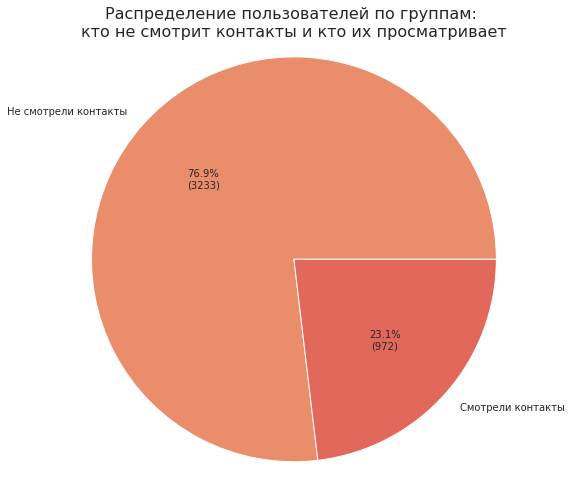

In [26]:
#подготавливаем данные
group_contacts = df.groupby('key_action').user_id.nunique().reset_index()
group_contacts['fraction'] = round((group_contacts['user_id'] / group_contacts['user_id'].sum()) * 100, 1)
group_contacts['key_action'] = group_contacts['key_action'].map({1: 'Смотрели контакты', 0: 'Не смотрели контакты'})
#создаём круговую диаграмму
plt.figure(figsize=(8, 8))
autopct = [f"{size:.1f}%\n({count})" for size, count in zip(group_contacts['fraction'], group_contacts['user_id'])]
plt.pie(group_contacts['user_id'], labels=group_contacts['key_action'], autopct=lambda pct: autopct.pop(0))
plt.title('Распределение пользователей по группам: \nкто не смотрит контакты и кто их просматривает', fontsize=16)
plt.axis('equal')
plt.show()

За четыре недели более трёх четвертей пользователей, участвовавших в нашем исследовании, ни разу не просмотрели контакты автора объявления. Лишь 23,1% пользователей совершили целевое действие.

---

Посмотрим, в каком соотношении пользователи привлекались из разных источников.

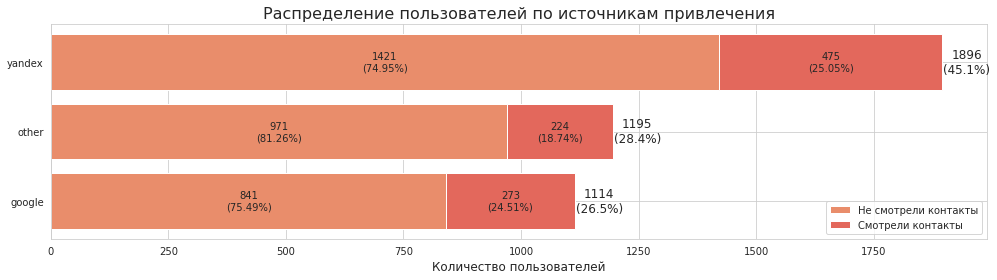

In [27]:
#подготавливаем данные
group_sources = df.pivot_table(index='source', columns='key_action', values='user_id', aggfunc='nunique').reset_index()
group_sources['total'] = group_sources.sum(axis=1)
group_sources['all'] = df['user_id'].nunique()
#создаём линейчатый график с накоплением
plt.figure(figsize=(14, 4))
bar1 = plt.barh(group_sources['source'], group_sources[0], color=palette[0])
bar2 = plt.barh(group_sources['source'], group_sources[1], left=group_sources[0], color=palette[1])
#добавляем отображение значений на столбиках
for i in range(len(group_sources)):
    total = group_sources['total'][i]
    fraction = round((total / group_sources['all'][i]) * 100, 1)
    plt.text(group_sources[0][i] / 2, i, 
             f'{group_sources[0][i]}\n({group_sources[0][i] / total * 100:.2f}%)', 
             ha='center', va='center') #не открывающие контакты
    plt.text(group_sources[0][i] + group_sources[1][i] / 2, i, 
             f'{group_sources[1][i]}\n({group_sources[1][i] / total * 100:.2f}%)', 
             ha='center', va='center') #открывающие контакты
    plt.text(total + 52, i, f'{total}\n({fraction}%)', ha='center', va='center', fontsize=12) #общая информация по источнику
#присваиваем название графика и описание по осям
plt.title('Распределение пользователей по источникам привлечения', fontsize=16)
plt.xlabel('Количество пользователей', fontsize=12)
plt.ylabel('')
plt.legend(['Не смотрели контакты', 'Смотрели контакты'])
plt.tight_layout()
plt.show()

- 45% пользователей приложения пришли через Яндекс. Из них почти 25% просматривали контакты. 
- Доля пользователей, пришедших через Google и просматривающих контакты, немногим меньше. Однако общее количество пользователей, пришедших через этот источник, почти в два раза меньше: 1114 против 1896.
- Остальные источники привлекли чуть больше пользователей, чем Google, но конверсия в просмотры у них хуже: 18,74% от этой группы.

---

Посмотрим на динамику использования приложения уникальными пользователями за каждый из дней. Поскольку запланировано рассмотреть динамику по нескольким показателям, создадим функции для построения линейных графиков с разделением и без.

In [28]:
#функция для линейного графика
def lineplot_construct(df, value, borders, title, ylabel):
    plt.figure(figsize=(14, 6))
    ax = sns.lineplot(data=df, x='day', y=value, marker='o', linewidth=3, palette=palette)
    #регулируем сетку
    ax.set_ylim(0, df[value].max() + borders)
    #задаём внешний вид датам по оси х
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m')) 
    #добавляем отсечки на конец недели
    for sunday in df['day'][df['day'].dt.weekday == 6]:
        ax.axvline(x=sunday, color=palette[2], linestyle='--', alpha=0.5)
    #подписываем опорные точки
    for index, row in df.iterrows():
        ax.text(row.day, row[value], f'{row[value]}', ha='center', va='bottom', color='black', fontsize=10)
    #присваиваем название графика и описание по осям
    plt.title(title, fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.tight_layout()
    plt.show()

In [29]:
#функция для линейного с разделением и столбчатого графиков
def line_and_barplot_construct(df, borders, title, ylabel):
    plt.figure(figsize=(14, 6))
    #линейный график
    for col in df.columns:
        sns.lineplot(data=df, x=df.index, y=col, marker='o', linewidth=3)
    #столбчатая диаграмма с общим количеством пользователей
    total_users = df.sum(axis=1)
    plt.bar(df.index, total_users, alpha=0.1, color='grey', width=0.8)
    #регулируем сетку
    plt.ylim(0, total_users.max() + borders)
    #задаём внешний вид датам по оси х
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    #добавляем отсечки на конец недели
    for sunday in df.index[df.index.weekday == 6]:
        plt.axvline(x=sunday, color=palette[2], linestyle='--', alpha=0.5)
    #подписываем опорные точки
    for index, row in df.iterrows():
        for col in df.columns:
            value = row[col]
            plt.text(index, value, f'{value}', ha='center', va='bottom', color='black', fontsize=10)
        total = total_users[index]
        plt.text(index, total, f'{total}', ha='center', va='bottom', color='black', fontsize=10, alpha=0.7)
    #присваиваем название графика и описание по осям
    plt.title(title, fontsize=16)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(['Не смотрели контакты', 'Смотрели контакты'])
    plt.tight_layout()
    plt.show()

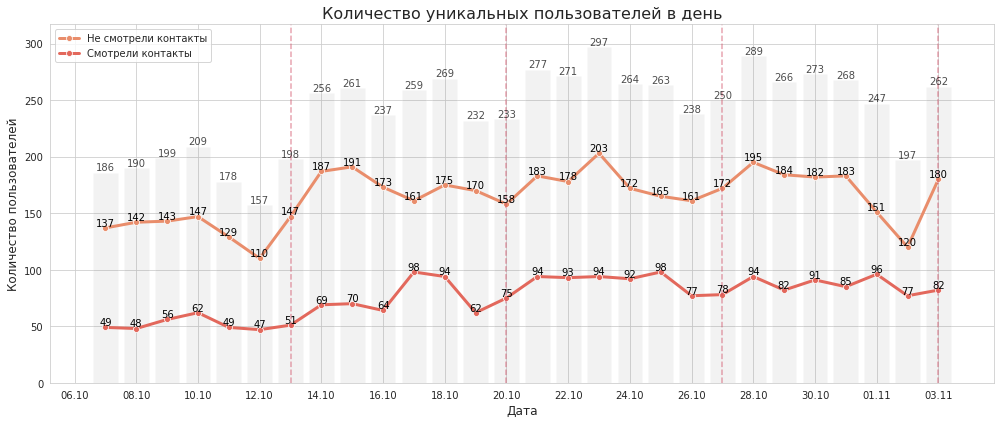

In [30]:
#подготавливаем данные
unique_daily_users = df.pivot_table(index='day', columns='key_action', values='user_id', aggfunc='nunique')
#создаём линейные с разделением и столбчатые графики
line_and_barplot_construct(unique_daily_users, 20, 'Количество уникальных пользователей в день', 'Количество пользователей')

На этом графике показано, как менялось количество пользователей в течение всего периода наблюдения. Мы видим пики и спады общей активности в разные дни. Однако к концу рассматриваемого периода число уникальных пользователей в день начало увеличиваться.
- Пользователи из целевой группы постепенно увеличивают свою активность в приложении в будние дни. Это приводит к росту числа уникальных пользователей в день.
- Хотя рост активности пользователей, которые не открывают контакты, не так значителен, он тоже присутствует.

---

Посмотрим, как менялось количество открытых сессий в приложении с 7 октября по 3 ноября 2019 года.

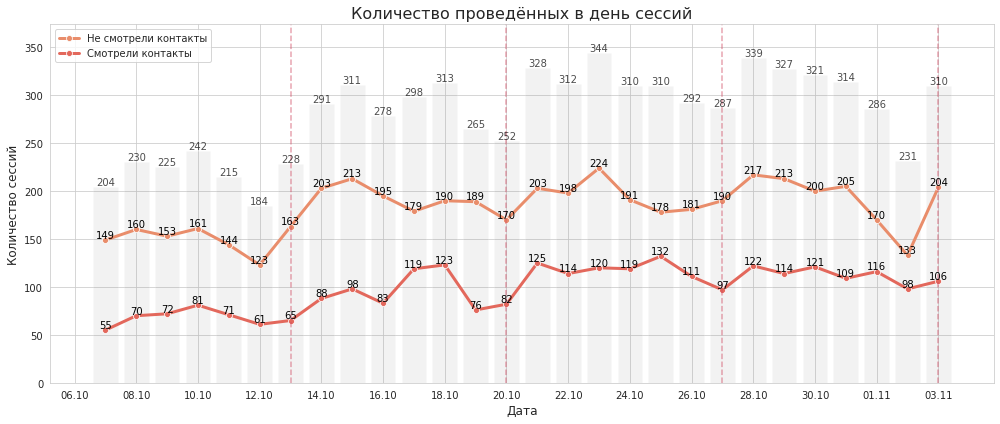

In [31]:
#подготавливаем данные
unique_daily_sessions = df.pivot_table(index='day', columns='key_action', values='session_id', aggfunc='nunique')
#создаём линейные с разделением и столбчатые графики
line_and_barplot_construct(unique_daily_sessions, 30, 'Количество проведённых в день сессий', 'Количество сессий')

Если посмотреть на динамику проведённых сессий, то можно заметить, что она очень похожа на изменчивость количества уникальных пользователей в день на протяжении всего периода. Колебания активности тесно связаны друг с другом. Однако к концу рассматриваемого периода количество сессий за день растёт более заметно.
- У пользователей, которые просматривают контакты, количество открытых за день сессий растет более стремительно, хотя в выходные дни наблюдается небольшое снижение посещаемости.
- У пользователей, которые не относятся к целевой группе, рост количества сессий в день менее стабилен и заметен.

---

Посмотрим, сколько сессий было у каждого пользователя за четыре недели. Поскольку будущие ящики с усами будут повторяться, создадим функцию для их построения.

In [32]:
#функция для боксплотов
def boxplot_construct(df,xticks,xlim,title,xlabel):
    plt.figure(figsize=(14, 2))
    sns.boxplot(x=df.values)
    plt.xticks(xticks)
    plt.xlim(xlim)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.tight_layout()
    plt.show()

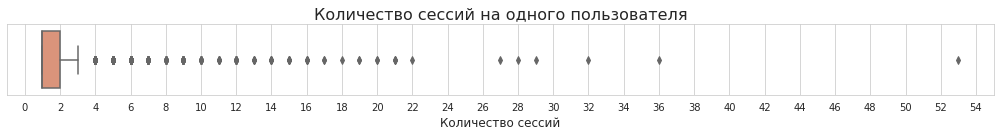

,count,mean,std,min,25%,50%,75%,max
session_id,4205.0,1.849941,2.282411,1.0,1.0,1.0,2.0,53.0


In [33]:
#подготавливаем данные
group_sessions = df.groupby('user_id').agg({'session_id': 'nunique'})
#строим боксплот
boxplot_construct(group_sessions, range(0, 55, 2), (-1, 55),
                  'Количество сессий на одного пользователя',
                  'Количество сессий')
#выводим статистику
group_sessions.describe().T

- Как минимум половина пользователей воспользовались приложением всего один раз за весь рассматриваемый период.
- Треть пользователей использовали приложение от 2 до 3 раз за 4 недели.
- Регулярное использование приложения кажется необычным, особенно учитывая, что один пользователь воспользовался им 53 раза. Следующие за ним по активности пользователи использовали приложение 36 и меньше раз с 7 октября по 3 ноября 2019 года.

---

Посмотрим, как распределено общее время, проведённое в приложении, у каждого пользователя из нашей выборки. 

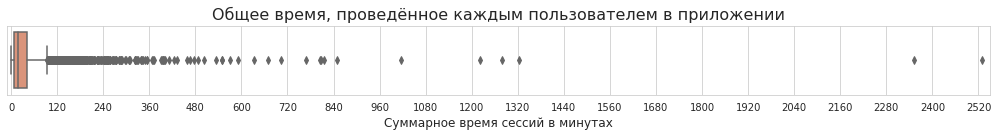

,count,mean,std,min,25%,50%,75%,max
session_time,4205.0,39.859176,90.722973,0.016667,6.883333,17.7,42.0,2529.05


In [34]:
#подготавливаем данные
group_time = df.groupby(['user_id', 'session_id']).session_time.first().groupby('user_id').sum() / 60
#строим боксплот
boxplot_construct(group_time, range(0, 2550, 120), (-10, 2550), 
                 'Общее время, проведённое каждым пользователем в приложении',
                 'Суммарное время сессий в минутах')
#выводим статистику
group_time.describe().to_frame().T

На этом графике мы видим, что некоторые пользователи провели в приложении немало времени. Особенно выделяется один пользователь, который пользовался приложением суммарно более 42 часов.

Большинство пользователей провели в приложении меньше часа. Рассмотрим график более подробно, увеличив масштаб до двух часов.

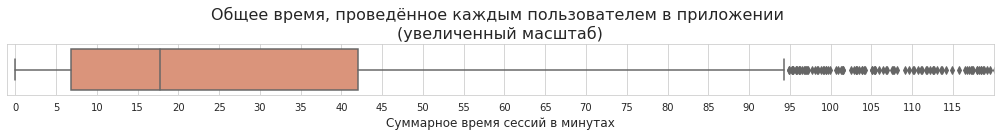

In [35]:
#строим боксплот в масштабе
boxplot_construct(group_time, range(0, 120, 5), (-1, 120), 
                 'Общее время, проведённое каждым пользователем в приложении \n(увеличенный масштаб)',
                 'Суммарное время сессий в минутах')

За рассматриваемый период половина пользователей проводили в приложении не более 17 минут, а судя по третьему квартилю, ещё треть пользователей использовали приложение до 42 минут за 28 дней. Это означает, что большинство пользователей проводят в приложении немного времени или используют его редко.

Любой пользователь, который суммарно провёл в приложении более 94 минут за 28 дней, будет выделяться на фоне остальных.

### Анализ целевой группы

Разделим пользователей на группы в зависимости от того, открывали ли они в рассматриваемый период контакты автора объявления.

In [36]:
viewers = df.query('key_action == 1').drop(columns = ['key_action'], axis = 1).reset_index(drop=True)
not_viewers = df.query('key_action != 1').drop(columns = ['key_action'], axis = 1).reset_index(drop=True)
#сравниваем результат с первоначальным датасетом
viewers.shape[0] + not_viewers.shape[0] == df.shape[0]

True

Всё в порядке: общий объём новых датасетов соответствует объёму исходных данных.

---

Посмотрим, как пользователи, которые хотя бы раз просматривали контакты за четыре недели, использовали приложение в этот период. Для этого создадим сводную таблицу, в которой подсчитаем количество сессий и общее время, проведённое в приложении с 7 октября по 3 ноября 2019 года.

In [37]:
#создаём сводную таблицу с информацией о сессиях у пользователей за каждый день
group_viewers = (viewers.groupby(['day','user_id','session_id']).session_time.first().reset_index()
                 .groupby(['day','user_id']).agg({'session_id':'count','session_time':'sum'}).reset_index())
#выводим результат
group_viewers

,day,user_id,session_id,session_time
0,2019-10-07,057a4dc6-0698-4662-ba56-64f2bc6e0adc,1,2735
1,2019-10-07,136b7b37-2bd4-4718-b14a-e38bc3d6d112,1,3182
2,2019-10-07,145009b0-bb47-4239-8afb-ad9a4b21ee2f,1,1436
3,2019-10-07,17f6b2db-2964-4d11-89d8-7e38d2cb4750,2,4349
4,2019-10-07,1a3361d1-2002-4389-a669-ecb06ea7a90a,2,672
...,...,...,...,...
2122,2019-11-03,ec70be94-3ea7-4ac2-90fb-da1a044d7e30,1,12308
2123,2019-11-03,f6f94ebe-e69a-4ae3-9fb0-312d52d35826,1,515
2124,2019-11-03,f73fb5e2-7b99-45a0-bffa-29ff320399c1,1,3207
2125,2019-11-03,f9c19253-73e7-4b9e-9630-45353a792248,1,62


Таблица сформирована корректно. Теперь рассмотрим среднее количество сессий за каждый день рассматриваемого периода. 

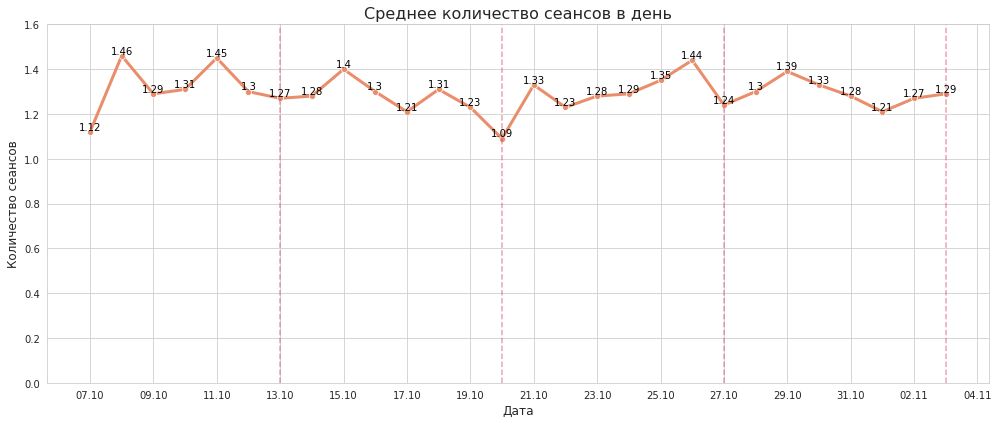

In [38]:
#подготавливаем данные
mean_count_sessions = group_viewers.groupby('day').session_id.mean().round(2).reset_index()
#создаём линейный график
lineplot_construct(mean_count_sessions, 'session_id', 0.14, 'Среднее количество сеансов в день', 'Количество сеансов')

Нет явной динамики, но есть заметные снижения активности в понедельник 7 октября и в воскресенье 20 октября. В эти дни пользователи заходили в приложение в среднем один раз в день, за редким исключением. Во все остальные дни некоторые пользователи заходили в приложение немного чаще. В целом, нельзя сказать, что частота посещений приложения у пользователей, просматривающих контакты, увеличилась или уменьшилась за рассматриваемый период. 

---

Изучим среднюю длительность сессий у пользователей, которые совершают целевое действие.

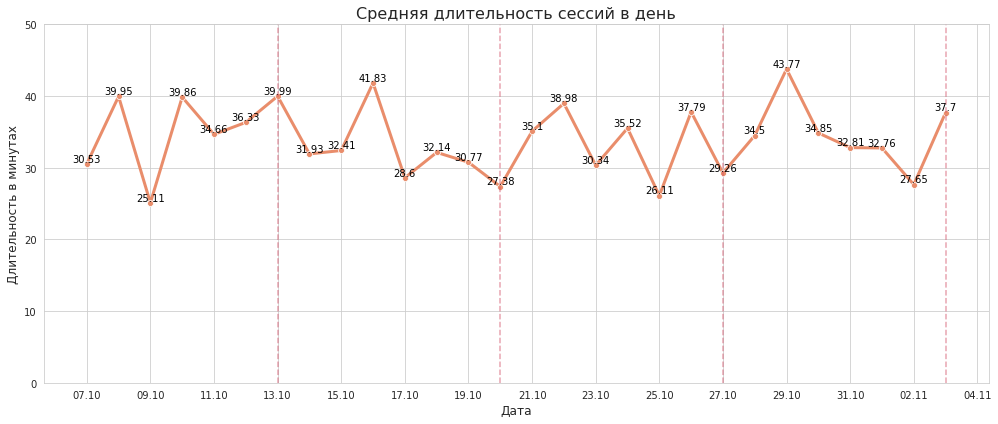

In [39]:
#подготавливаем данные
mean_time_sessions = group_viewers.groupby('day').session_time.mean().reset_index()
mean_time_sessions['session_time'] = (mean_time_sessions['session_time'] / 60).round(2)
#создаём линейный график
lineplot_construct(mean_time_sessions, 'session_time', 6.23, 'Средняя длительность сессий в день', 'Длительность в минутах')

Из этого графика можно сделать вывод, что в среднем люди, которые просматривают контакты, проводят в приложении около получаса. Однако этот показатель не является стабильным и постоянно меняется в пределах одного диапазона: от 25 до 40 минут. 

Возможно, более наглядным будет медианный график, так как на него не так сильно влияют выбросы.

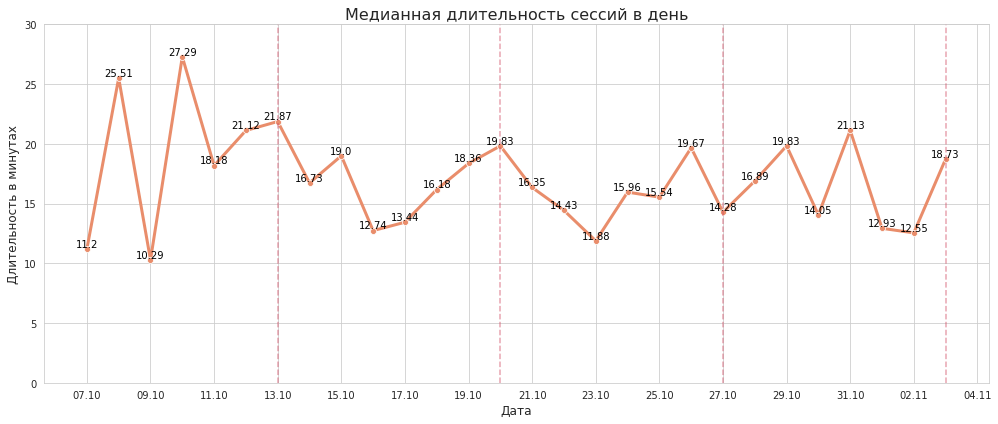

In [40]:
#подготавливаем данные
median_time_sessions = group_viewers.groupby('day').session_time.median().reset_index()
median_time_sessions['session_time'] = (median_time_sessions['session_time'] / 60).round(2)
#создаём линейный график
lineplot_construct(median_time_sessions, 'session_time', 2.71, 'Медианная длительность сессий в день', 'Длительность в минутах')

Согласно медианному графику, в приложении ежедневно были пользователи, которые проводили там много времени. Из-за этого средние значения сильно изменились: обычно большинство пользователей проводят в приложении около 20 минут или меньше. Исключение составили только 8 и 10 октября, когда половина пользователей провели в приложении до получаса.

В целом можно заметить, что начало и конец периода не были стабильными. Однако с 16 по 20 октября наблюдалось постепенное увеличение медианного времени, проведённого в приложении, а затем в течение ещё трёх дней — стабильный спад.

---

Мы отобрали из датасета всех пользователей, которые хотя бы раз просматривали контакты автора объявления. Посмотрим, как часто они совершали целевое действие за изучаемый период.

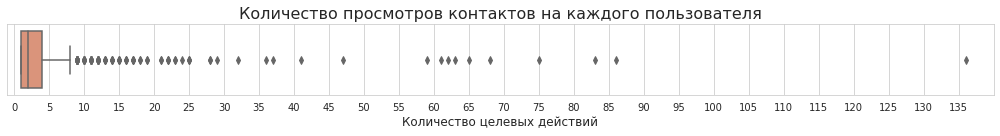

,count,mean,std,min,25%,50%,75%,max
event_name,951.0,4.485804,9.065119,1.0,1.0,2.0,4.0,136.0


In [41]:
#подготавливаем данные
group_action = viewers.query('event_name == "contacts_show"').groupby('user_id').event_name.count()
#строим боксплот
boxplot_construct(group_action, range(0, 140, 5), (-1, 140),
                  'Количество просмотров контактов на каждого пользователя',
                  'Количество целевых действий')
#выводим статистику
group_action.describe().to_frame().T

Треть пользователей совершили целевое действие только один раз, ещё треть — до четырёх раз, при этом медиана остановилась на двух. Однако есть и те, кто просматривает контакты довольно часто.

---

Проверим, существует ли связь между продолжительностью сессии и количеством совершённых целевых действий.

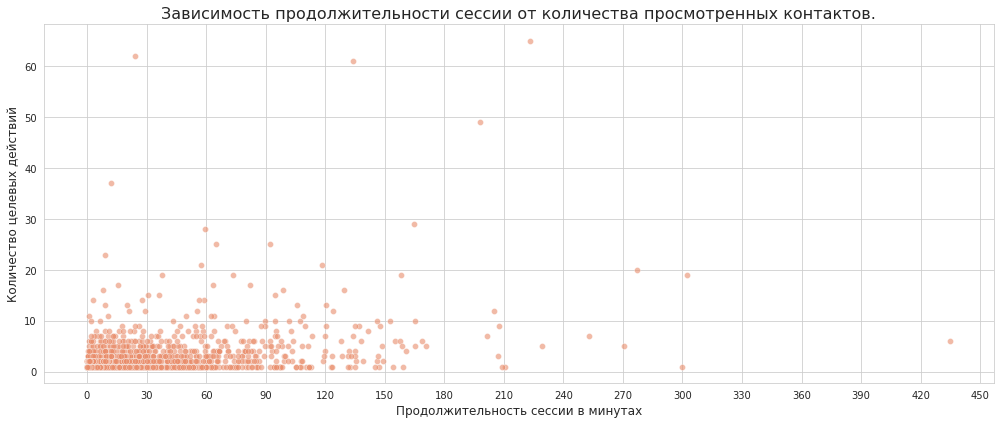

Корреляция продолжительности сессии и количеству целевых действий: 0.3442749114923608


In [42]:
#подготавливаем данные
corr_action = (viewers.query('event_name == "contacts_show"')
               .groupby('session_id').agg({'session_time':'first', 'event_name':'count'}))
corr_action['session_time'] /= 60
#строим график корреляции 
plt.figure(figsize=(14, 6))
sns.scatterplot(x='session_time', y='event_name', data=corr_action, alpha=0.6)
plt.title('Зависимость продолжительности сессии от количества просмотренных контактов.', fontsize=16)
plt.xlabel('Продолжительность сессии в минутах', fontsize=12)
plt.ylabel('Количество целевых действий', fontsize=12)
plt.xticks(range(0, 455, 30))
plt.tight_layout()
plt.show()
#считаем корреляцию
print('Корреляция продолжительности сессии и количеству целевых действий:', 
      corr_action['session_time'].corr(corr_action['event_name']))

Зависимость не подтверждается: есть как длительные сессии с небольшим количеством просмотренных контактов, так и короткие сессии с аномально большим количеством выполненных целевых действий.

---

Разделим сессии на ряд действий, которые завершаются просмотром контактов, для более детального изучения поведения пользователей. Так как звонок не является целевым действием, мы будем его игнорировать, если он совершён сразу после просмотра контактов. Если группа логов состоит из одинаковых повторяющихся действий, то дубли мы также удалим.

In [43]:
#создаём отдельный датасет
data = viewers[['user_id','event_time', 'event_name','session_id']].copy()
#сортируем его в обратном порядке
data = data.sort_values(by=['session_id', 'event_time'], ascending=False)
#определяем, выполнено ли целевое действие
data['new_group'] = data['event_name'].isin(['contacts_show'])
#делим каждую сессию на группы
data['session_group'] = data.groupby('session_id')['new_group'].cumsum()
#создаём уникальные идентификаторы групп
data['group_id'] = data.groupby(['session_id', 'session_group'], sort=False).ngroup()
#сортируем датасет назад
data = data.sort_values(by=['user_id', 'event_time'])
#удаляем повторяющиеся действия в группе
data['prev_event'] = data.groupby('group_id')['event_name'].shift(1)
data = data[data['event_name'] != data['prev_event']]
#проверяем, какое первое действие в группе
data['first_action'] = data.groupby('group_id').cumcount() == 0
data = data[~((data['first_action']) & (data['event_name'] == 'contacts_call'))]
#удаляем вспомогательные столбцы
data = data.drop(columns=['new_group', 'session_group', 'first_action', 'prev_event'])
#проверяем результат на рандомном участке
data.loc[0:25]

,user_id,event_time,event_name,session_id,group_id
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,search,5,6428
3,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:40:38.990477,photos_show,5,6428
7,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:58:00.109019,search,5,6428
8,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:59:54.637098,photos_show,5,6428
9,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 18:49:24.115634,search,6,6427
10,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 18:59:22.541082,photos_show,6,6427
11,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:03:02.030004,favorites_add,6,6427
12,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:04:16.149734,search,6,6427
15,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:17:18.659799,contacts_show,6,6427
17,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:18:54.738758,photos_show,6,6426


После того как мы разделили логи на группы и удалили дубликаты, видим, что некоторые группы теперь содержат только одно целевое действие или не содержат просмотра контактов. Это не поможет нам понять, как пользователи ведут себя до совершения целевого действия. Поэтому мы удалим такие группы.

In [44]:
#удаляем группы с количеством действий до 2
data = data[~data['group_id'].isin(data.groupby('group_id').filter(lambda x: len(x) < 2)['group_id'])]
#отбираем группы действий с просмотром контактов
group_list = data.query('event_name == "contacts_show"')['group_id'].unique()
data = data[data['group_id'].isin(group_list)]
#проверяем результат на рандомном участке
data.loc[0:25]

,user_id,event_time,event_name,session_id,group_id
9,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 18:49:24.115634,search,6,6427
10,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 18:59:22.541082,photos_show,6,6427
11,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:03:02.030004,favorites_add,6,6427
12,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:04:16.149734,search,6,6427
15,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:17:18.659799,contacts_show,6,6427
17,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:18:54.738758,photos_show,6,6426
19,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:23:11.839947,contacts_show,6,6426
23,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:57:15.652784,photos_show,6,6424
25,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 20:04:53.349091,contacts_show,6,6424


Проверим, какого размера группы у нас присутствуют.

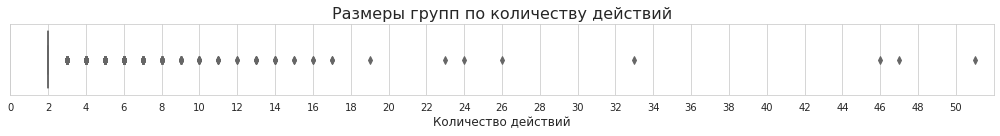

,count,mean,std,min,25%,50%,75%,max
event_time,2438.0,2.687449,2.4478,2.0,2.0,2.0,2.0,51.0


In [45]:
#подготавливаем данные
group_data = data.groupby('group_id').event_time.count()
#строим боксплот
boxplot_construct(group_data, range(0, 52, 2), (0, 52), 'Размеры групп по количеству действий', 'Количество действий')
#выводим статистику
group_data.describe().to_frame().T

Чаще всего сценарии, приводящие к просмотру контактов, состоят из ряда в 2 уникальных действия, но в некоторых случаях до просмотра контактов пользователи совершили больше разнообразных манипуляций в приложении. Редкие и длительные случаи не репрезентативны, потому высчитаем их и тоже удалим.

In [46]:
#высчитываем перцентили
np.percentile(group_data, [95, 99])

array([ 5., 11.])

Сценарии, включающие более 5 последовательных уникальных действий, составляют всего 5% от общего числа групп. Мы сохраним для анализа остальные 95% логов о поведении пользователей, которое приводит к просмотру контактов.

In [47]:
#удаляем группы действий с аномально большим количеством событий
data = (data[~data.group_id.isin(group_data[group_data > np.percentile(group_data, 95)].index)]
        [['group_id','event_time', 'event_name']].reset_index(drop=True))
#выводим статистику
data.groupby('group_id').event_time.count().describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
event_time,2321.0,2.315381,0.70072,2.0,2.0,2.0,2.0,5.0


Мы удалили аномально большие сценарии. Для анализа у нас остались наиболее популярные сценарии поведения пользователей и ряд менее популярных, но с большим количеством действий в цепочке.

---

Подготовим ряд функций, которые обращаются друг к другу и формируют диаграмму Сэнкея, чтобы рассмотреть сценарии, которые приводят к целевому действию.

In [48]:
#первая функция: добавление новых признаков к исходной таблице
def add_features(df):
    sorted_df = df.sort_values(by=['group_id', 'event_time'])
    sorted_df['step'] = sorted_df.groupby('group_id').cumcount() + 1
    sorted_df['source'] = sorted_df['event_name']
    sorted_df['target'] = sorted_df.groupby('group_id')['source'].shift(-1)
    return sorted_df.drop(['event_name'], axis=1)

#вторая функция: генерация индексов source
def get_source_index(df):
    df = add_features(df) #обращаемся к первой функции
    res_dict = {}
    count = 0
    for no, step in enumerate(df['step'].unique().tolist()):
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict

#третья функция: генерация кастомных цветов
def colors_for_sources(df):
    #создаём свою палитру на основе опорных цветов
    colors = ['#ECAE7F','#C34167','#552665']
    n_colors = 8
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_colors)
    custom_palette = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]    
    df = add_features(df) #обращаемся к первой функции
    colors_dict = {}       
    for no, label in enumerate(df['source'].unique()):
        colors_dict[label] = custom_palette[no % len(custom_palette)]
    return colors_dict

#четвёртая функция: расчёт уникальных id в процентах
def percent_users(sources, targets, values):
    zip_lists = list(zip(sources, targets, values))
    new_list = []
    unique_dict = {}
    for source, target, value in zip_lists:
        if source not in unique_dict:
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    return new_list

#пятая функция: создание необходимых для отрисовки диаграммы переменных списков
def lists_for_plot(df, source_indexes, colors_dict, frac=0):
    df = add_features(df) #обращаемся к первой функции
    sources = []
    targets = []
    values = []
    labels = []
    colors_labels = []
    link_color = []
    link_text = []
    for step in tqdm(sorted(df['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue
        temp_dict_source = source_indexes[step]['sources_dict']
        temp_dict_target = source_indexes[step+1]['sources_dict']
        for source, index_source in temp_dict_source.items():
            for target, index_target in temp_dict_target.items():
                temp_df = df[(df['step'] == step) & (df['source'] == source) & (df['target'] == target)]
                value = len(temp_df)
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    rgba_c = mcolors.to_rgba(colors_dict[source], alpha=0.2)
                    rgba_color_str = f'rgba({int(rgba_c[0]*255)}, {int(rgba_c[1]*255)}, {int(rgba_c[2]*255)}, {rgba_c[3]})'
                    link_color.append(rgba_color_str)
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors_dict[name])
    perc_values = percent_users(sources, targets, values) #обращаемся к четвёртой функции
    link_text = [f"{perc}%" for perc in perc_values]
    return {'sources': sources, 'targets': targets, 'values': values, 'labels': labels,
            'colors_labels': colors_labels,'link_color': link_color, 'link_text': link_text}

#шестая функция: отрисовка диаграммы Сэнкея
def plot_senkey_diagram(df, title, height, frac=0):
    source_indexes = get_source_index(df) #обращаемся ко второй функции
    colors_dict = colors_for_sources(df) #обращаемся к третьей функции
    data_for_plot = lists_for_plot(df, source_indexes, colors_dict, frac) #обращаемся к пятой функции
    fig = go.Figure(data=[go.Sankey(domain=dict(x=[0, 1], y=[0, 1]), orientation='h', valueformat='.0f',
                                    node=dict(pad=15, thickness=10, line=dict(color='black', width=0.1),
                                              label=data_for_plot['labels'], color=list(data_for_plot['colors_labels'])),
                                    link=dict(source=data_for_plot['sources'],
                                              target=data_for_plot['targets'],
                                              value=data_for_plot['values'],
                                              label=data_for_plot['link_text'],
                                              color=list(data_for_plot['link_color'])))])
    fig.update_layout(title_text=title, font_size=10, title_font_size=16, 
                      width=980, height=height, margin=dict(l=10, r=10, t=30, b=10))
    return fig

Шаг: 100%|██████████| 5/5 [00:00<00:00, 29.39it/s]


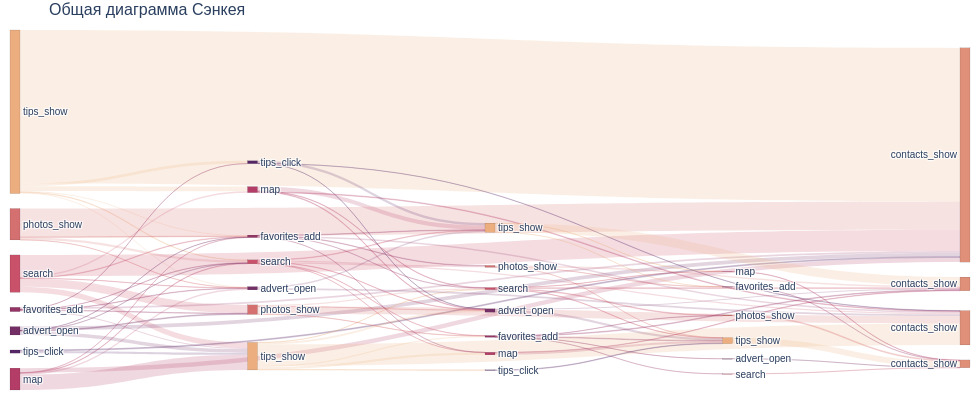

In [49]:
#сохраняем график как изображение png для github
pio.write_image(plot_senkey_diagram(data, 'Общая диаграмма Сэнкея', 400), 
                'figure.png', width=980, height=400, scale=1)
Image('figure.png')

Самые распространённые сценарии состоят из двух шагов. По мере того как в цепочке появляется больше событий, частота открытия контактов снижается.

Поскольку в группах событий может быть разное количество шагов, общая диаграмма затрудняет детальный анализ. Поэтому мы разделим набор данных на группы в зависимости от количества шагов в цепочке и последовательно создадим диаграммы для каждой из них. Это позволит нам лучше рассмотреть последовательность действий, приводящих к просмотру контактов, в сценариях разной продолжительности.

Шаг: 100%|██████████| 2/2 [00:00<00:00, 303.01it/s]


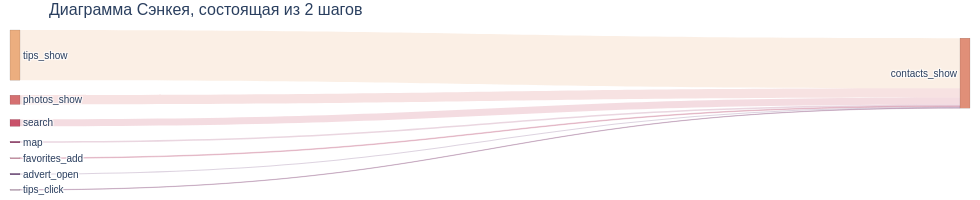

Шаг: 100%|██████████| 3/3 [00:00<00:00, 67.89it/s]


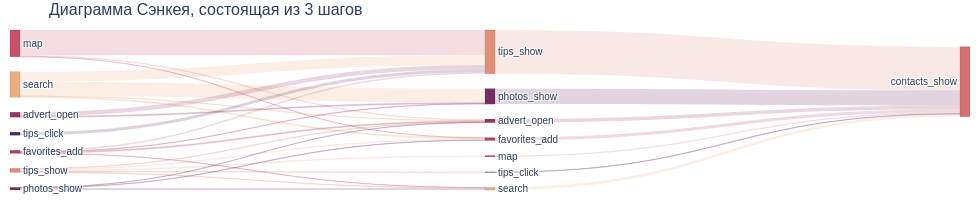

Шаг: 100%|██████████| 4/4 [00:00<00:00, 65.93it/s]


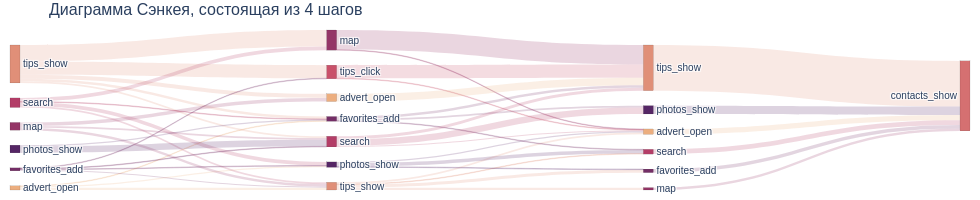

Шаг: 100%|██████████| 5/5 [00:00<00:00, 59.51it/s]


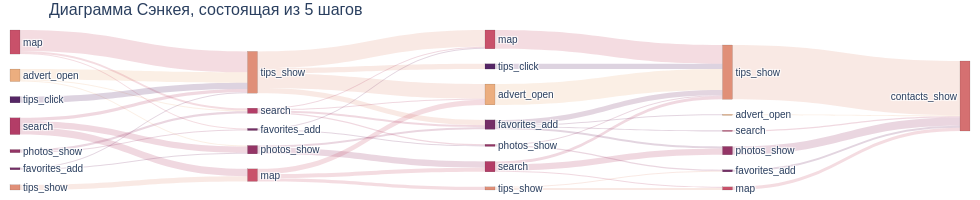

In [50]:
#цикл по длительности цепочек
for value in data.groupby('group_id').event_time.count().sort_values().unique():
    table = data[data['group_id'].isin(group_data[group_data == value].index)]
    fig = plot_senkey_diagram(table, f'Диаграмма Сэнкея, состоящая из {value} шагов',200)
    #сохраняем график как изображение png для github
    pio.write_image(fig, 'figure.png', width=980, height=200, scale=1)
    display(Image('figure.png'))

- Самый распространённый сценарий:`tips_show`=>`contacts_show`. Однако, такой быстрый переход не свидетельствует об успешно проведённой сделке. Если пользователь сразу после просмотра рекомендованного объявления переходит к просмотру контактов, это характеризует его скорее как любопытного, чем внимательного покупателя. Даже 243 случая перехода от карты к контактам или 182 — от поискового запроса к контактам больше напоминают простую заинтересованность. Опираться на такие короткие сценарии рискованно, поскольку они не гарантируют успешного исхода сделки.

- Трёхшаговые цепочки более информативны. Наиболее частые переходы:
    - `map`=>`tips_show`=>`contacts_show`: пользователи ищут объявления по территориальной близости и изучают рекомендованные объявления.
    - `search`=>`photos_show`=>`contacts_show`: пользователи сначала просматривают фотографии вещей, которые нашли через поиск, и на основе изображений принимают решение об открытии контактов.
    - `search`=>`tips_show`=>`contacts_show`: пользователи целенаправленно ищут по определённым характеристикам, затем рассматривают предложенные вещи и открывают контакты заинтересовавших объявлений.
    
- Сценарии из четырёх шагов:
    - Переход от просмотра предложенных объявлений к картам или открытию объявлений с последующим возвращением к просмотру контактов указывает на нерешительность пользователей. Такие пользователи словно перепроверяют свой выбор, прежде чем перейти к контактам.

- Пятишаговые сценарии встречаются реже, но также имеют свои характерные особенности:
    - `map`=>`tips_show`=>`map`=>`tips_show`=>`contacts_show`: пользователи регулярно сверяют местоположение автора объявления и предложенные вещи.
    - `map`=>`tips_show`=>`advert_open`=>`tips_show`=>`contacts_show`: пользователи просматривают карты и предложенные объявления, затем изучают карточки объявлений и возвращаются к рекомендованным объявлениям перед просмотром контактов.
    - `search`=>`map`=>`advert_open`=>`tips_show`=>`contacts_show`: пользователи после настройки фильтров в поиске изучают карты, открывают карточки и просматривают рекомендованные объявления, затем открывают контакты.
    - `search`=>`photos_show`=>`search`=>`photos_show`=>`contacts_show`: пользователи уточняют поисковые запросы и ориентируются по фотографиям перед открытием контактов в объявлении.
    
Этот анализ показывает, что более длинные сценарии поведения пользователей дают лучшее понимание их намерений и мотивов, чем короткие и поспешные переходы. 

---

Для построения воронки рассмотрим три сценария, состоящих из 3 шагов:
- map, tips_show, contacts_show
- search, photos_show, contacts_show
- search, tips_show, contacts_show


Для проведения расчётов нам понадобятся ряд фильтров, которые помогут определить уникальных пользователей, переходящих от одного действия к другому. Поэтому создадим функции, упрощающие эти вычисления.

In [51]:
#сохраняем популярные цепочки действий
scenarios = [['map', 'tips_show', 'contacts_show'],
             ['search', 'photos_show', 'contacts_show'],
             ['search', 'tips_show', 'contacts_show']]

In [52]:
#функция для посдчёта конверсии в цепочках
def get_funnel_steps(df, steps):
    results = []
    users = set(df.user_id.unique())
    #проходим по каждому шагу в цепочке
    for step in steps:
        df_filtered = df[df['user_id'].isin(users)]
        users = set(df_filtered[df_filtered['event_name'] == step]['user_id'])
        unique_users = len(users)
        results.append((step, unique_users))
    return pd.DataFrame(results, columns=['event_name', 'unique_users'])
#функция для построения воронки
def funnel_construct(index, df, scenarios=scenarios):
    #создаём пустой список
    funnel_results = []
    #применяем функцию get_funnel_steps
    for scenario in scenarios:
        funnel_results.append(get_funnel_steps(df, scenario))
    scenario_key = ' -> '.join(scenarios[index])
    scenario_df = funnel_results[index]    
    #создаём воронку конверсии
    fig = px.funnel(funnel_results[index], x='unique_users', y='event_name', 
                    title=f'Воронка для сценария: {scenario_key}', labels={'event_name': ''})
    #костыль для смещения воронки
    annotations = []
    for i, row in scenario_df.iterrows():
        annotations.append(dict(x=row['unique_users']-450,y=row['event_name'], text='',showarrow=False))
    #настраиваем визуализацию
    fig.update_traces(marker=dict(color='#ECAE7F'), textinfo='label+value+percent initial+percent previous',
                     insidetextanchor='start', textposition='outside')
    fig.update_layout(autosize=False, width=980, height=400, margin=dict(l=10, r=10, b=10, t=50, pad=10), 
                      title_font_size=16, yaxis=dict(showticklabels=False), annotations=annotations, plot_bgcolor='white')
    return fig

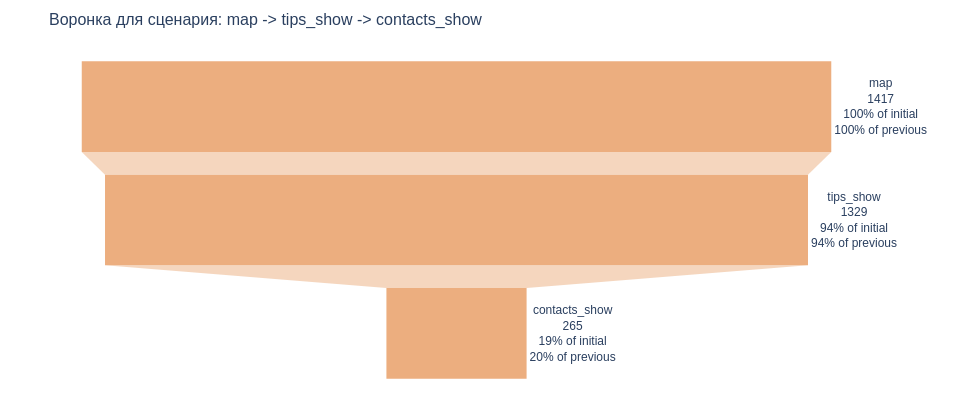

In [53]:
#строим воронку по первому сценарию и сохраняем график как изображение png для github
pio.write_image(funnel_construct(0, df), 'figure.png', width=980, height=400, scale=1)
Image('figure.png')

Сценарий, при котором пользователи ориентируются на территориальное положение автора объявления, демонстрирует хорошую конверсию: 19% пользователей, изучивших карту перед просмотром объявления, переходят к просмотру контактов. Потери между первым и вторым шагом составляют всего 6%. Это означает, что если пользователь начинает с просмотра карты, он с высокой вероятностью перейдёт к рекомендованным объявлениям. Из них 20% пользователей затем открывают контакты, что указывает на высокий уровень заинтересованности пользователей из этого сценария.

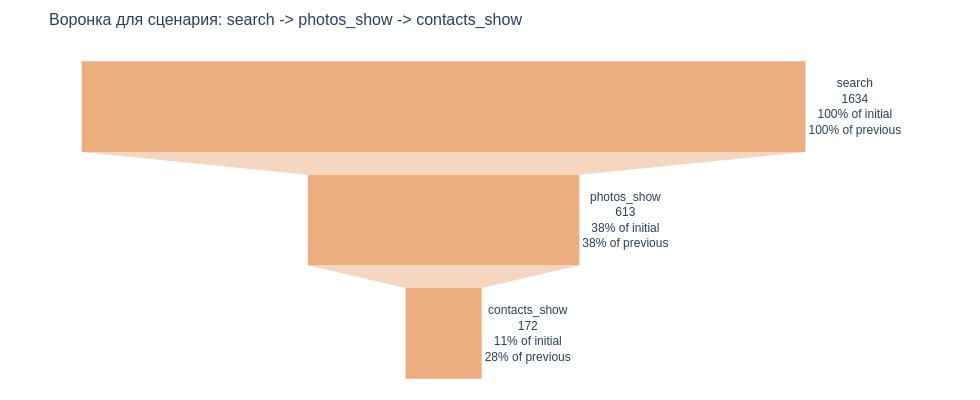

In [54]:
#строим воронку по второму сценарию и сохраняем график как изображение png для github
pio.write_image(funnel_construct(1, df), 'figure.png', width=980, height=400, scale=1)
Image('figure.png')

Изначально большее число пользователей обращается к поисковым запросам. Из них 38% переходят к просмотру фотографий предлагаемых вещей, и далее 28% решают открыть контакты автора объявления. Хотя финальная конверсия составляет всего 11% от числа начавших поиск, доля пользователей, перешедших к контактам после просмотра фотографий, является весьма значимой.

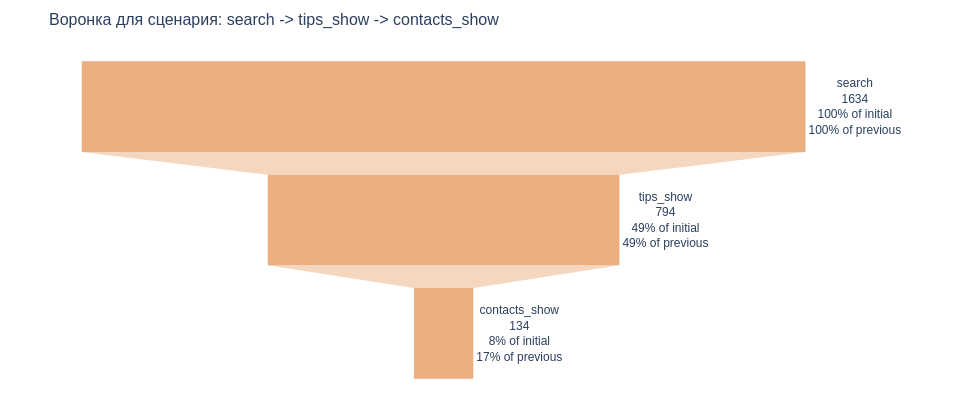

In [55]:
#строим воронку по третьему сценарию и сохраняем график как изображение png для github
pio.write_image(funnel_construct(2, df), 'figure.png', width=980, height=400, scale=1)
Image('figure.png')

Сценарий, включающий поиск, просмотр предложенных объявлений и переход к контактам, демонстрирует самую низкую конверсию среди рассмотренных вариантов: только 8% от начавших поиск и 17% от тех, кто просматривал предложенные объявления, переходят к контактам. Это позволяет предположить, что результаты такого поведения менее надежны. Лучше не полагаться на быстрый переход от предложенных объявлений к контактам без проявления большей заинтересованности, так как вероятность успешной сделки в этом случае может быть ещё ниже.

---

Теперь мы определим относительную частоту событий для пользователей, которые открывают и не открывают контакты, чтобы выделить те, которые характерны для пользователей из целевой аудитории.

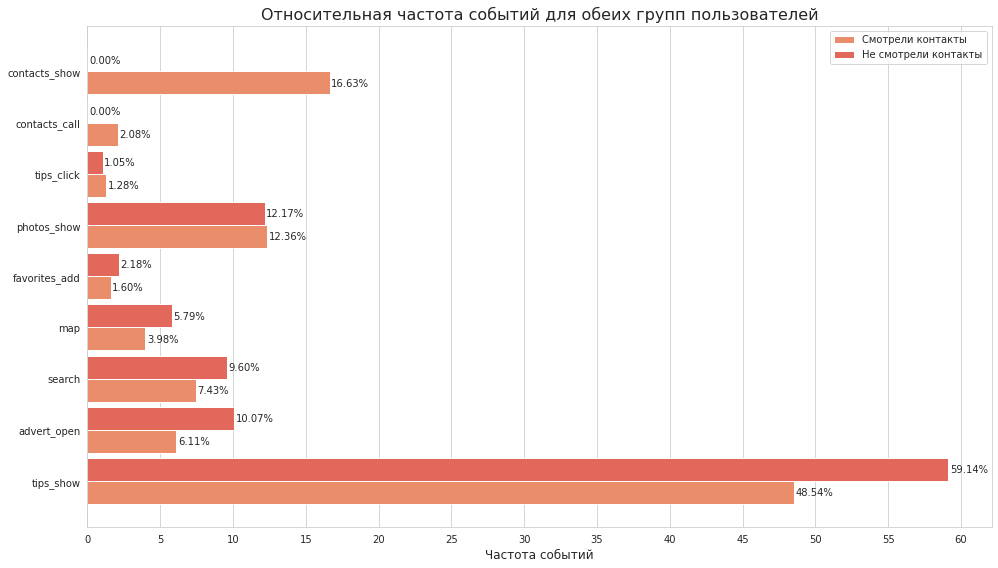

In [56]:
#рассчитываем частоту каждого действия в обеих группах
viewers_count = viewers['event_name'].value_counts().reset_index(name='viewers_count')
viewers_count['viewers_relative'] = viewers_count['viewers_count'] / viewers['event_time'].count() * 100
not_viewers_count = not_viewers['event_name'].value_counts().reset_index(name='not_viewers_count')
not_viewers_count['not_viewers_relative'] = not_viewers_count['not_viewers_count'] / not_viewers['event_time'].count() * 100
#объединяем частотные таблицы
freqs = pd.merge(viewers_count, not_viewers_count, on='index', how='outer').fillna(0)
#высчитываем разницу в относительных частотах
freqs['difference'] = freqs['viewers_relative'] - freqs['not_viewers_relative']
freqs = freqs.sort_values(by='difference').reset_index(drop=True)
#создаём линейчатый график
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.45
index = range(len(freqs))
bar1 = ax.barh(index, freqs['viewers_relative'], height=bar_width, label='Смотрели контакты')
bar2 = ax.barh([i + bar_width for i in index], freqs['not_viewers_relative'], height=bar_width, label='Не смотрели контакты')
#добавляем отображение значений на столбиках
for i, v in enumerate(freqs['viewers_relative']):
    ax.text(v + 0.1, i, f'{v:.2f}%', va='center')
for i, v in enumerate(freqs['not_viewers_relative']):
    ax.text(v + 0.1, i + bar_width, f'{v:.2f}%', va='center')
#присваиваем название графика и описание по осям
ax.set_yticks([i + bar_width / 2 for i in index])
ax.set_yticklabels(freqs['index'])
ax.set_xlabel('Частота событий', fontsize=12)
ax.set_title('Относительная частота событий для обеих групп пользователей', fontsize=16)
ax.grid(axis='y')
plt.xticks(range(0, 65, 5))
ax.legend()
plt.tight_layout()
plt.show()

- Просмотр рекомендованных объявлений — самое распространенное действие в обеих группах, но более характерно для пользователей, не открывающих контакты. Это событие не является специфическим для целевой группы.
- Открытие контактов составляет 16,63% от всех действий пользователей, которые просматривают контакты, в то время как звонки через приложение совершаются лишь в 2,08% случаев.
- Просмотр фото в объявлении — третье по частоте событие, популярное в обеих группах. Однако, у целевой группы этот показатель немного выше: 12,36% против 12,17%.
- Использование поиска, открытие карточек и просмотр карты часто встречаются у целевой группы, но эти действия не являются их отличительной чертой, так как пользователи, не открывающие контакты, делают это чаще.
- Клик на рекомендованное объявление является характерным действием для пользователей, которые затем открывают контакты.
- Добавление объявлений в избранное у целевой группы происходит в 1,6% случаев, в то время как у остальных пользователей этот показатель выше — 2,18%, но это не приводит к открытию контактов.

## Проверка гипотез

<a id='section_id20'></a>
Нулевая и альтернативная гипотезы для сравнения конверсии у пользователей, которые совершают только `tips_show` и те, что совершает и`tips_show`, и `tips_click` будет следующими:
- **Гипотеза H0**: Конверсия в просмотры контактов пользователей, которые совершают только `tips_show`, и которые совершают `tips_show` и `tips_click` — равна.
- **Гипотеза H1**: Конверсия в просмотры контактов пользователей, которые совершают только `tips_show`, отличается от конверсии пользователей, которые совершают `tips_show` и `tips_click`

Чтобы проверить эти гипотезы, мы отберём множества пользователей, которые выполняли необходимые действия и просмотрели контакты, а затем сформируем выборки для проведения теста. Для снижения вероятности ошибки первого рода за уровень статистической значимости примем 1%. 
Поскольку эти две выборки не связаны между собой, мы сможем применить статистический тест с использованием t-распределения.

In [57]:
#собираем множество пользователей, которые просмотрели контакты
contacts_show = set(df.query('event_name == "contacts_show"').user_id.unique())
#собираем множества пользователей по условиям выполненных действий
tips_show = set(df.query('event_name == "tips_show"').user_id.unique())
tips_click = set(df.query('event_name == "tips_click"').user_id.unique())
only_tips_show = tips_show - tips_click
show_and_click = tips_show & tips_click
#создаем выборки для двух групп
sampling_only_tips_show = [1 if user in contacts_show else 0 for user in only_tips_show]
sampling_show_and_click = [1 if user in contacts_show else 0 for user in show_and_click]
#уровень статистической значимости
alpha = 0.01
#проверяем гипотезу, сравнивая выборки
results = st.ttest_ind(sampling_only_tips_show, sampling_show_and_click)
p_value = results.pvalue
print('Конверсия у пользователей, совершающих только tips_show:', 
      len(only_tips_show & contacts_show) / len(only_tips_show) * 100)
print('Конверсия у пользователей, совершающих tips_show и tips_click:', 
      len(show_and_click & contacts_show) / len(show_and_click) * 100)
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: конверсии различаются')
else:
    print('Не можем отвергнуть нулевую гипотезу: конверсии не различаются')

Конверсия у пользователей, совершающих только tips_show: 16.991869918699187
Конверсия у пользователей, совершающих tips_show и tips_click: 30.16949152542373
p-value: 3.165761964255006e-08
Отвергаем нулевую гипотезу: конверсии различаются


Вероятность, что разница в конверсии между группами пользователей, которые только увидели рекомендованные объявления и которые увидели объявления и кликнули по ним, возникла случайно, крайне мала: примерно 0,00000003%. Это позволяет сделать вывод, что конверсия двух этих групп различается.

---

Для сравнения конверсии пользователей, добавляющих объявления в избранное, и конверсии пользователей, открывающих объявления, мы выдвигаем следующие гипотезы:

- **Гипотеза H0:** Конверсия в просмотры контактов пользователей, совершающих `favorites_add`, равна конверсии пользователей, совершающих `advert_open`.
- **Гипотеза H1:** Конверсия в просмотры контактов пользователей, добавляющих объявления в избранное, выше, чем у пользователей, открывающих карточки объявлений.

Чтобы выборки были независимыми, мы исключим из обеих групп пересечения действий. Здесь мы также будем использовать Т-тест со статистической значимостью 1%.

In [58]:
#собираем множества пользователей по условиям выполненных действий
favorites_add = set(df.query('event_name == "favorites_add"').user_id.unique())
advert_open = set(df.query('event_name == "advert_open"').user_id.unique())
only_favorites_add = favorites_add - advert_open
only_advert_open = advert_open - favorites_add
#создаем выборки для двух групп
sampling_favorites_add = [1 if user in contacts_show else 0 for user in only_favorites_add]
sampling_advert_open = [1 if user in contacts_show else 0 for user in only_advert_open]
#уровень статистической значимости
alpha = 0.01
#проверяем гипотезу, сравнивая выборки
results = st.ttest_ind(sampling_favorites_add, sampling_advert_open, alternative = 'greater')
p_value = results.pvalue
print('Конверсия у пользователей, совершающих favorites_add:', 
      len(only_favorites_add & contacts_show) / len(only_favorites_add) * 100)
print('Конверсия у пользователей, совершающих advert_open:', 
      len(only_advert_open & contacts_show) / len(only_advert_open) * 100)
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: конверсия у favorites_add выше')
else:
    print('Не можем отвергнуть нулевую гипотезу: конверсии не различаются')

Конверсия у пользователей, совершающих favorites_add: 31.11111111111111
Конверсия у пользователей, совершающих advert_open: 12.738853503184714
p-value: 1.757916617790833e-10
Отвергаем нулевую гипотезу: конверсия у favorites_add выше


Полученное значение p-value (~0,00000000018) значительно меньше заданного уровня значимости. Поэтому мы можем отвергнуть нулевую гипотезу и сделать вывод, что у пользователей, которые добавляют объявления в избранное, конверсия в просмотры контактов выше, чем у тех, кто только открывает карточки объявлений. 

---

Нулевая и альтернативная гипотезы для сравнения источников привлечения пользователей, которые совершают целевые действия в приложении, можно сформулировать следующим образом:

- **Гипотеза H0:** Вероятность просмотра контактов у пользователей, которые пришли в приложение через `yandex` и `google`, одинакова.
- **Гипотеза H1:** Вероятность просмотра контактов у пользователей, пришедших через `yandex` и `google`, отличается.

Для проверки этих гипотез мы также по аналогии применим Т-тест со статистической значимостью 1%.

In [59]:
#собираем множества пользователей по условиям выполненных действий
yandex = set(df.query('source == "yandex"').user_id.unique())
google = set(df.query('source == "google"').user_id.unique())
#создаем выборки для двух групп
sampling_yandex = [1 if user in contacts_show else 0 for user in yandex]
sampling_google = [1 if user in contacts_show else 0 for user in google]
#уровень статистической значимости
alpha = 0.01
#проверяем гипотезу, сравнивая выборки
results = st.ttest_ind(sampling_yandex, sampling_google)
p_value = results.pvalue

print('Конверсия у пользователей, пришедших через yandex:', 
      len(yandex & contacts_show) / len(yandex) * 100)
print('Конверсия у пользователей, пришедших через google:', 
      len(google & contacts_show) / len(google) * 100)
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: конверсия у favorites_add выше')
else:
    print('Не можем отвергнуть нулевую гипотезу: конверсии не различаются')

Конверсия у пользователей, пришедших через yandex: 24.68354430379747
Конверсия у пользователей, пришедших через google: 24.057450628366247
p-value: 0.6997020916795681
Не можем отвергнуть нулевую гипотезу: конверсии не различаются


Результаты теста показали, что разница в конверсиях между пользователями, пришедшими из Yandex и Google, с вероятностью почти 70% может быть случайной. Это означает, что у нас нет достаточных статистических данных, чтобы утверждать, что конверсии отличаются. Поэтому мы не можем отвергнуть предположение о том, что конверсии среди пользователей из этих двух источников одинаковы. 

## Общие выводы и рекомендации

В ходе анализа данных, собранных с 7 октября по 3 ноября 2019 года, мы обнаружили, что большинство пользователей не просматривали контакты за этот период. Тем не менее, наблюдался постепенный рост количества уникальных пользователей и числа открытых сессий, что свидетельствует о возрастающем интересе к приложению «Ненужные вещи». Однако это пока не привело к заметному увеличению вовлечённости целевой группы: среднее количество сеансов и средняя длительность сессий у пользователей, открывающих контакты, остаются стабильными и не показывают значительного роста.

Наиболее перспективные сценарии включают использование поиска, изучение карты и просмотр фотографий в объявлениях. Эти шаги обычно предшествуют открытию контактов, что указывает на потенциал повышения конверсии. 
- Рекомендуется обратить особое внимание на интеграцию поиска с картами и предложение в рекомендации объявлений, находящихся ближе к пользователю географически.

Добавление объявлений в избранное также является характерной чертой пользователей, открывающих контакты. Это подтверждает гипотезу о том, что удобный доступ к избранным объявлениям может стимулировать совершение целевого действия.

Клики по рекомендованным объявлениям также положительно коррелируют с открытием контактов. 
- Рекомендуется внедрить игровой элемент, например, изменение цвета объявления после клика, чтобы стимулировать пользователей чаще взаимодействовать с рекомендованными объявлениями.

Наконец, по результатам проверки гипотезы о лидерах источников привлечения (yandex vs google) не было выявлено статистически значимой разницы в конверсии. Это подтверждает стабильность выбранных каналов привлечения, однако стоит продолжать мониторинг и оптимизацию каналов для долгосрочного роста.

Эти меры помогут увеличить вовлечённость пользователей и рост конверсии в просмотры контактов, что в свою очередь повысит вероятность успешных сделок через приложение «Ненужные вещи».

### [Презентация в формате PDF](https://disk.yandex.ru/i/AgYSTYto9Kykkw)